# Project: Identify Customer Segments
##### This work is completed as a part of UDACITY project

In this project, unsupervised learning techniques are used to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.


In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import math
from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline



### Load the Data


In [267]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';') ## Seperated by ";"

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [268]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('azdias shape :', azdias.shape)
print('feat_info shape :', feat_info.shape)

azdias shape : (891221, 85)
feat_info shape : (85, 4)


In [269]:
azdias.head() ## printing first 5 rows

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [270]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]



## Preprocessing

###  Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. First of all, we should assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. So, we need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.


In [271]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))


In [272]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [273]:
for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attrib] == value, attrib] = np.nan

In [274]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing.  While some of these columns might have justifications for keeping or re-encoding the data, for this project we should just remove them from the dataframe. 

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [275]:
 #Perform an assessment of how much missing data there is
# in each column of the dataset.
attribute = []
rate_nan = [] 
for k in azdias.columns:
    attribute.append(k)
    rate_nan.append(azdias[k].isnull().sum()*100./len(azdias))

df_nan = pd.DataFrame({'attribute': attribute, 'Percentage of NaN': rate_nan })

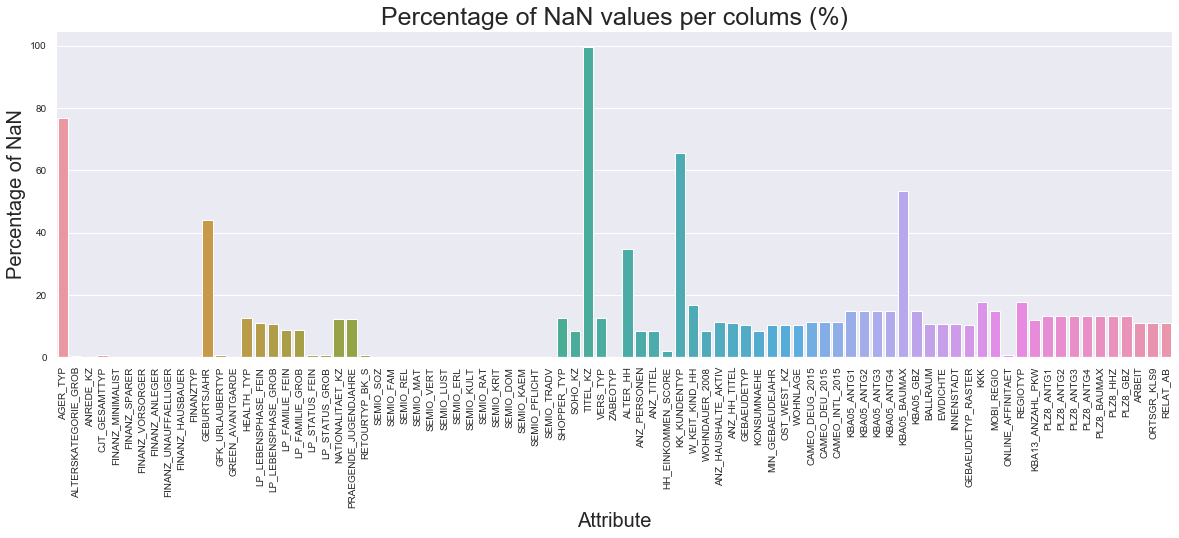

In [298]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(20, 6))
sns.barplot(x="attribute", y="Percentage of NaN", orient='v', data=df_nan)
plt.xticks(rotation=90)
matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=20)
plt.title('Percentage of NaN values per colums (%)',fontsize=25)
plt.xlabel("Attribute",fontsize=20)
plt.ylabel("Percentage of NaN",fontsize=20)
plt.show()


In [277]:
outliers = df_nan[df_nan['Percentage of NaN'] > 20]['attribute'].values.tolist()
outliers

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [278]:
clean = df_nan[df_nan['Percentage of NaN'] == 0]['attribute'].values.tolist()
clean

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [279]:
# Remove the outlier columns from the dataset
azdias =  azdias.drop(outliers, axis=1)

#### Assess Missing Data in Each Column

The bar plot above shows that percentage of missing or NaN values in each column. The missing data patterns can be summarized in three groups. In the first group, columns have missing values ranging from 10-20% (~ more than half of the data), in the second group, columns have no missing values or ver few (<1%), and in the third group, only few columns have shown missing values more than 30%. The columns with missing values more than 30% are 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX' attributes. So, the third group attributes should be removed for the further analysis. 

#### Assess Missing Data in Each Row

Now,perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.


Depending on what we observe in the comparison, this will have implications on how we approach the conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special.

In [280]:
# How much data is missing in each row of the dataset?
azdias['num NaN'] = azdias.apply(lambda row: row.isnull().sum(), axis=1)

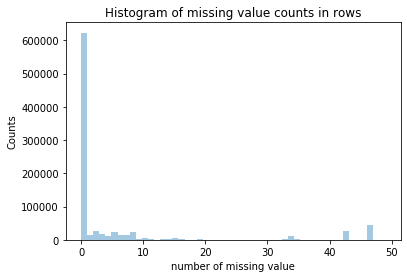

In [281]:
###Lets plot visualize missing counts in row
plt.figure()
sns.distplot(azdias['num NaN'], kde=False)
plt.xlabel('number of missing value')
plt.ylabel('Counts')
plt.title('Histogram of missing value counts in rows')
plt.show()


In [282]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_below = azdias[azdias['num NaN'] < 10]
azdias_above = azdias[azdias['num NaN'] >= 10]

In [283]:
print(len(azdias_below))
print(len(azdias_above))
print(len(azdias_below)/(len(azdias_below)+len(azdias_above)))

774743
116478
0.8693051442908101


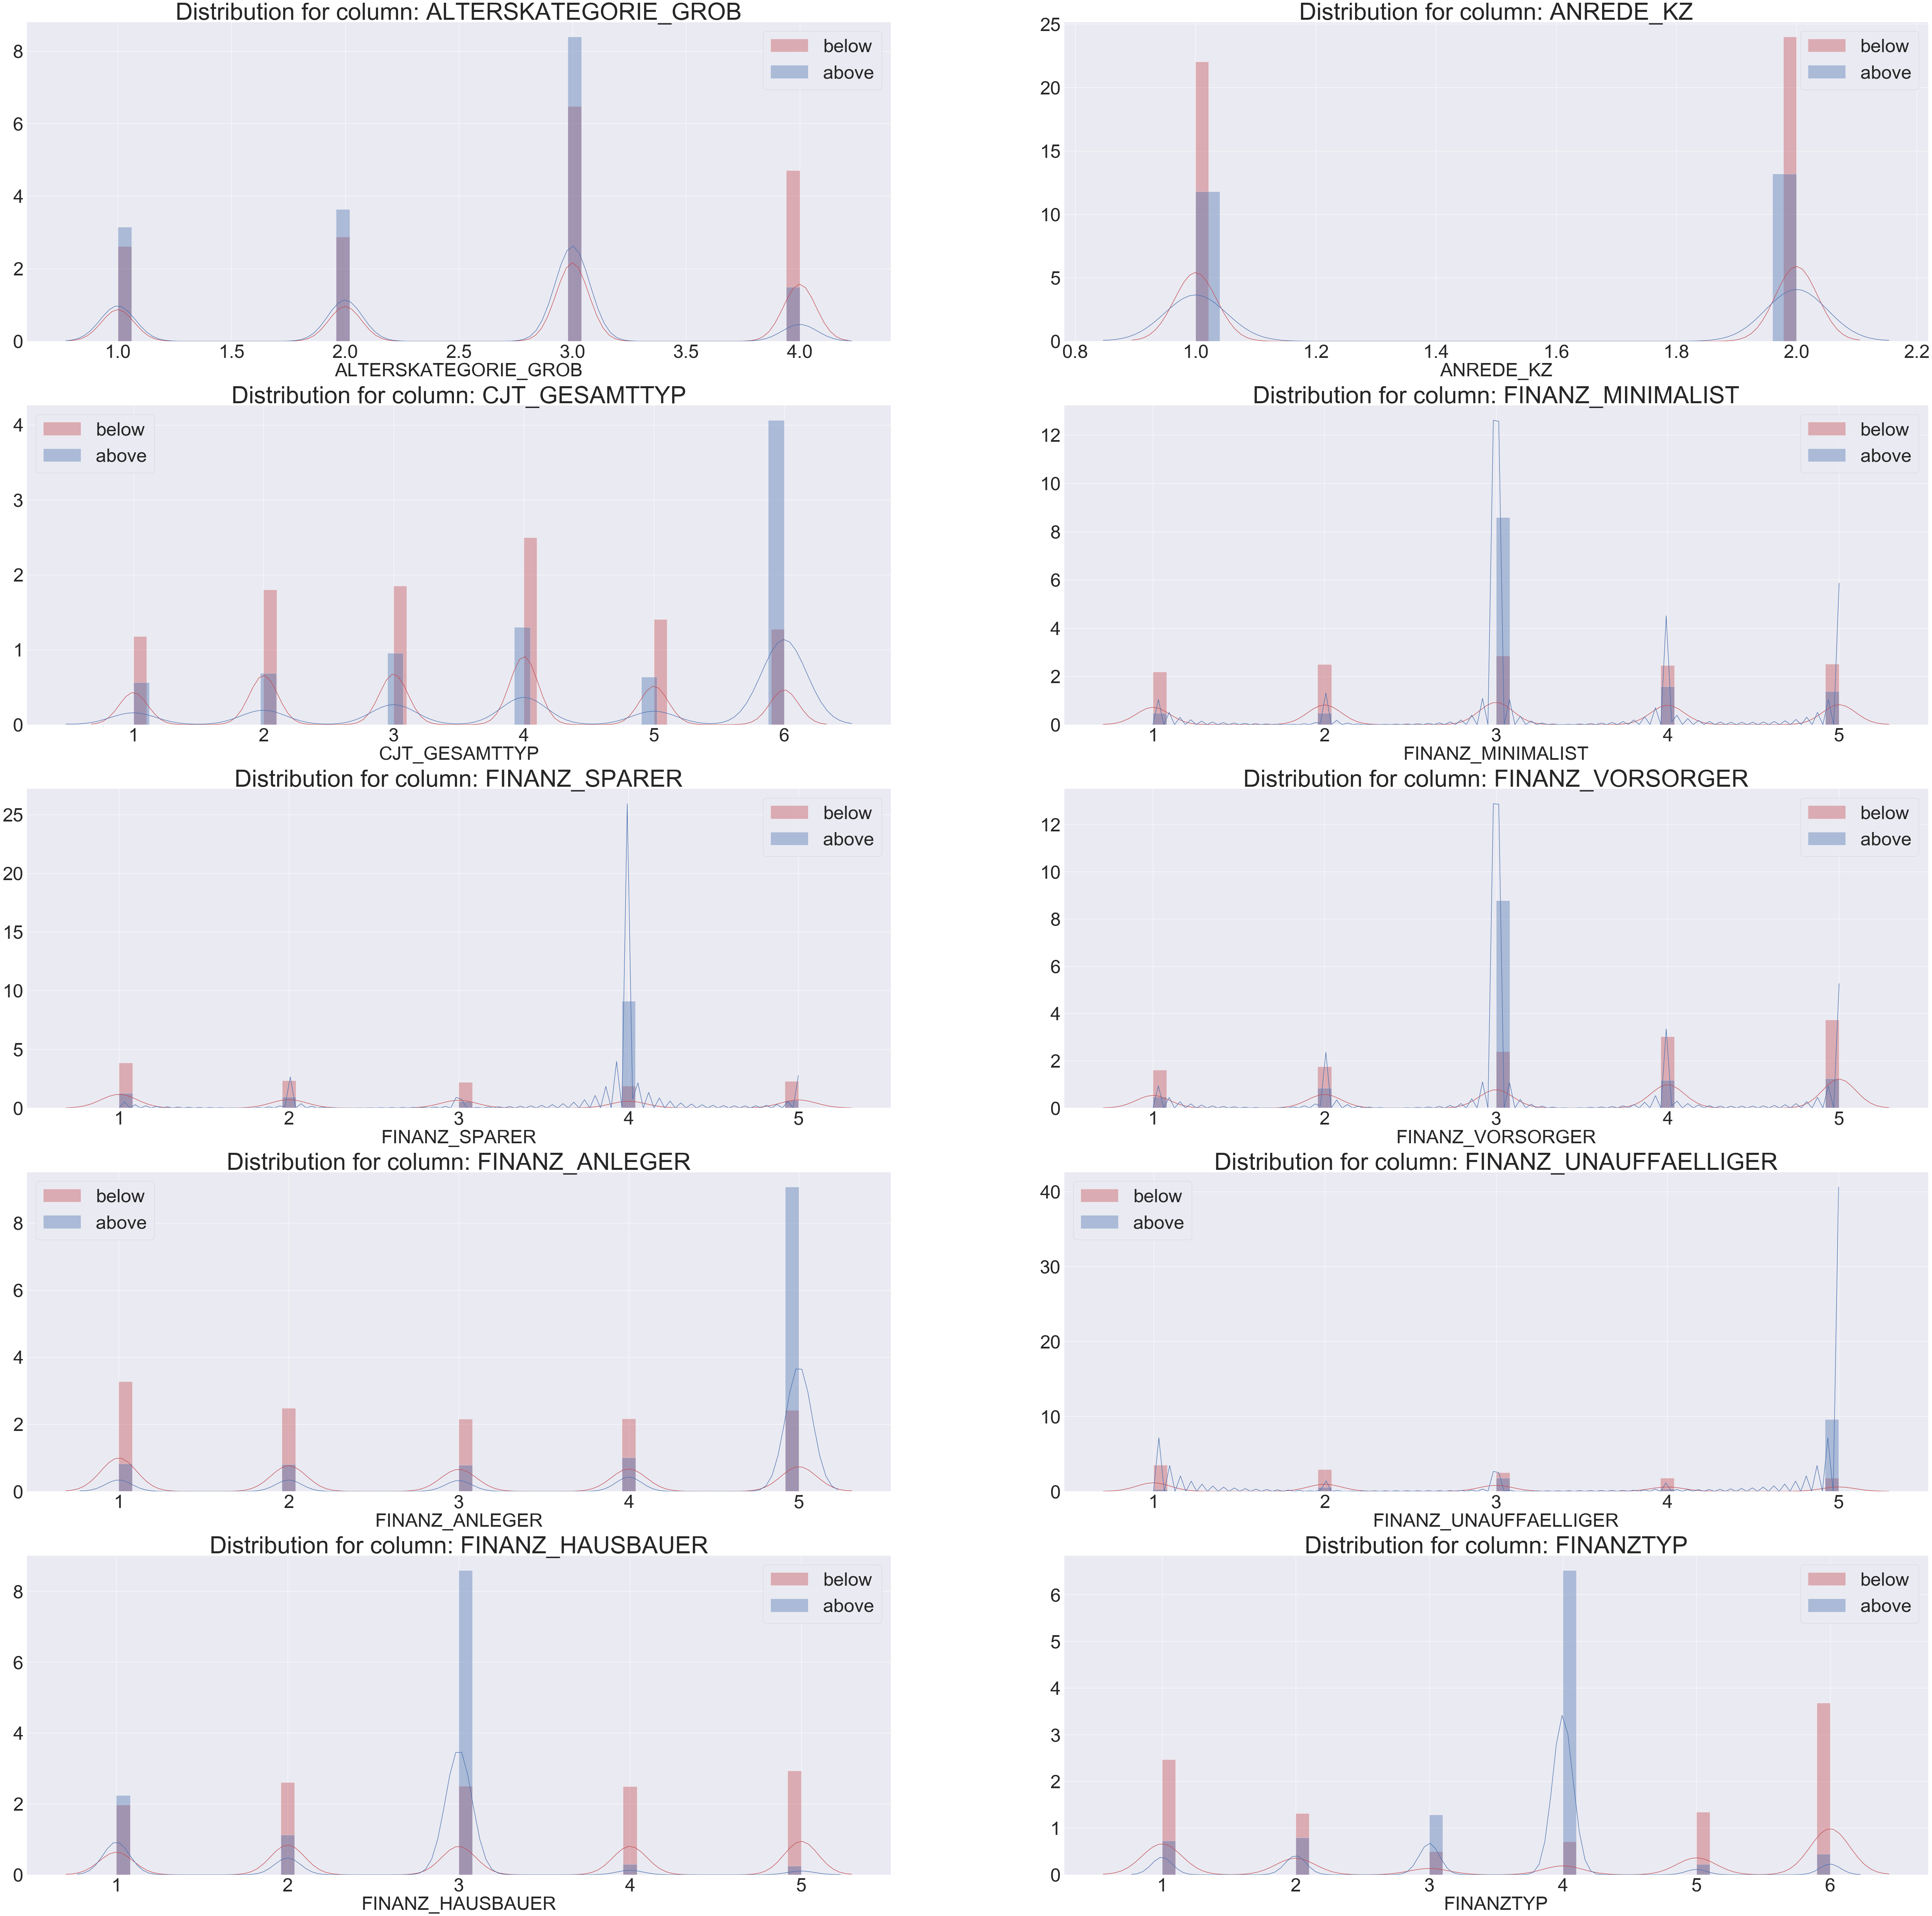

In [292]:
plt.figure(figsize=(100,100))
sns.set(font_scale = 5)
for i, col in enumerate(azdias.columns[: 10]):
    
    plt.subplot(5, 2, i+1)
    sns.distplot(azdias_below[col][azdias_below[col].notnull()], color='r', label='below')
    sns.distplot(azdias_above[col][azdias_above[col].notnull()], color='b', label='above')
    
    plt.title('Distribution for column: {}'.format(col),fontsize=70)
    plt.legend(fontsize=55)
    plt.xlabel(col,fontsize=55)
    

In [176]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def dest(data_1, data_2, clm = ''):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=clm, data=data_1)
    plt.subplot(1, 2, 2)
    sns.countplot(x=clm, data=data_2)
    plt.show()

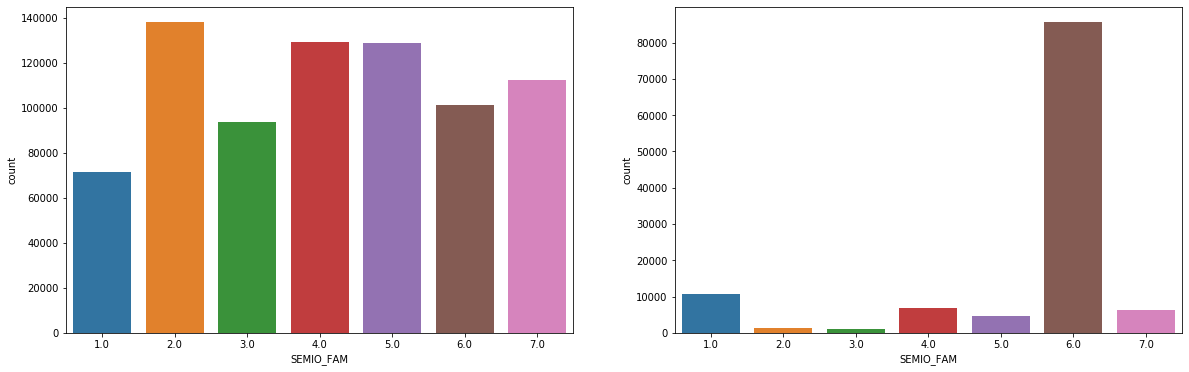

In [177]:
dest(azdias_below, azdias_above, clm=clean[10])

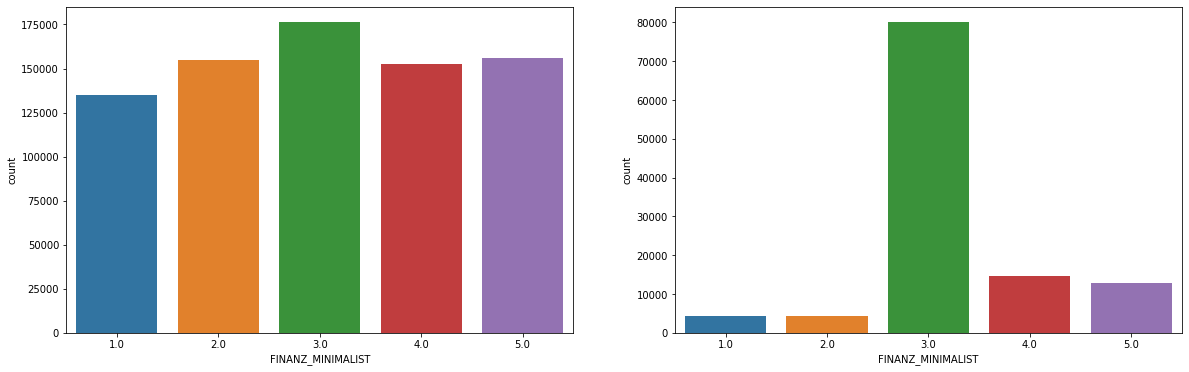

In [178]:
dest(azdias_below, azdias_above, clm=clean[1])

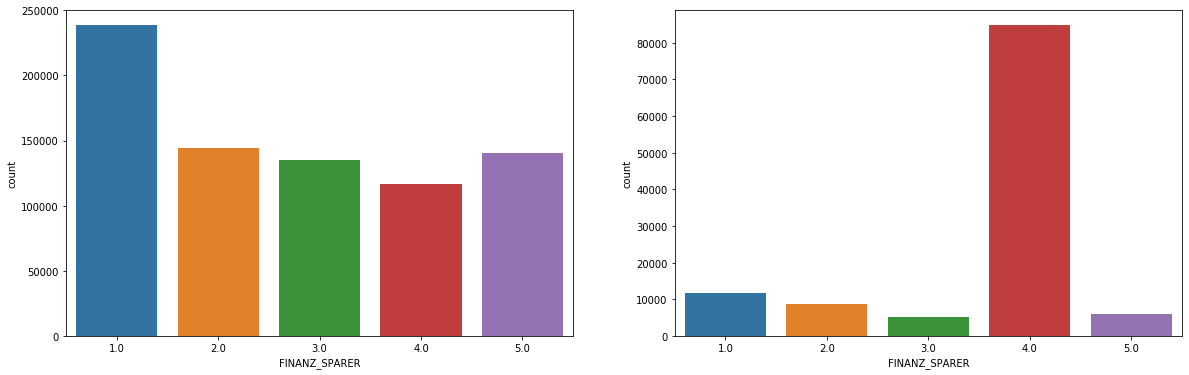

In [179]:
dest(azdias_below, azdias_above, clm=clean[2])

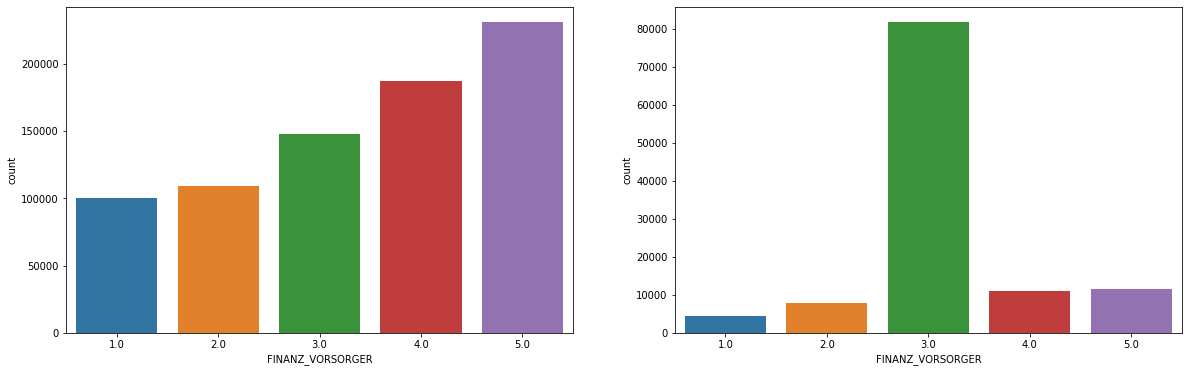

In [180]:
dest(azdias_below, azdias_above, clm=clean[3])

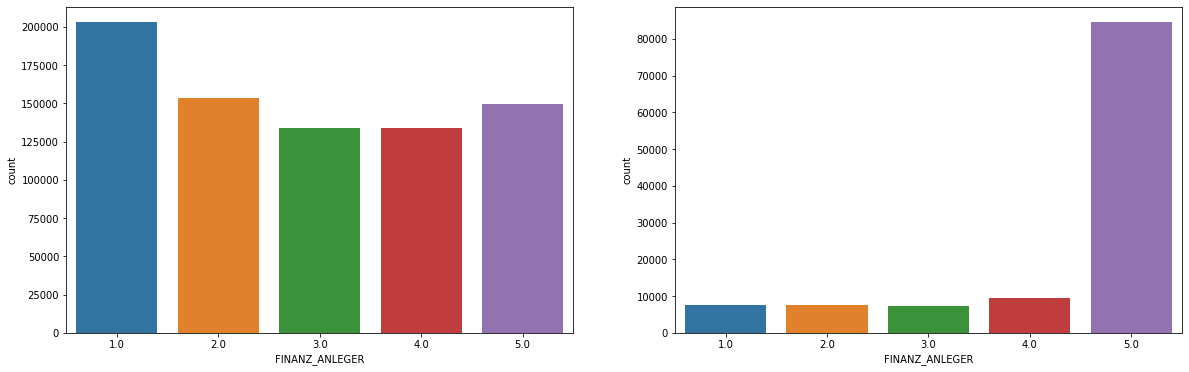

In [181]:
dest(azdias_below, azdias_above, clm=clean[4])

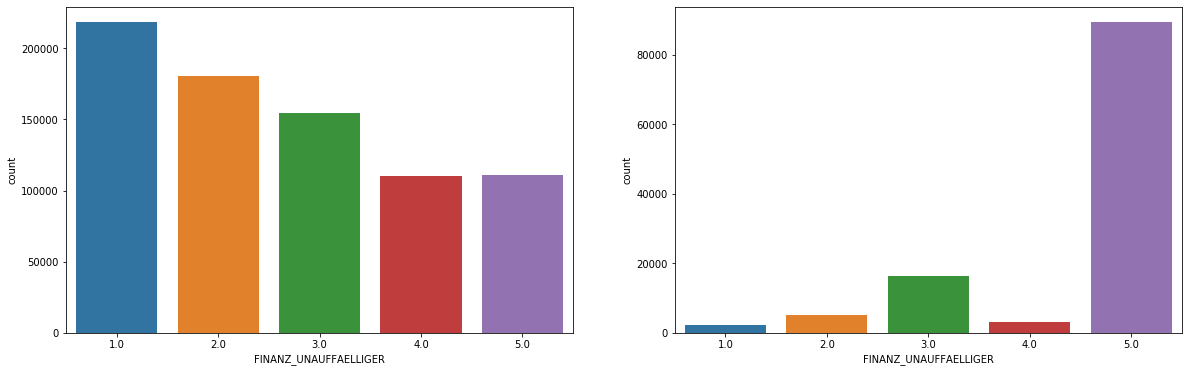

In [182]:
dest(azdias_below, azdias_above, clm=clean[5])

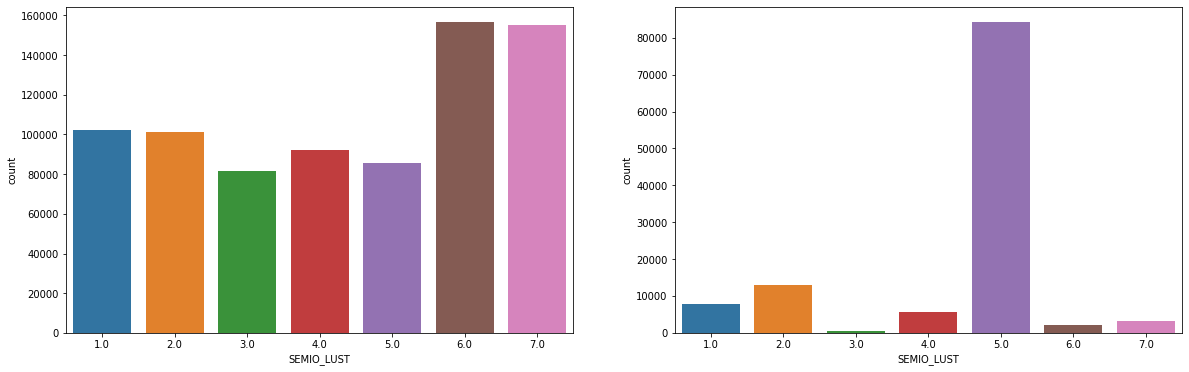

In [183]:
dest(azdias_below, azdias_above, clm=clean[14])

In [184]:
## remove lines that contain more than 10 nan values
azdias = azdias[azdias['num NaN'] < 10]

In [185]:
azdias.shape

(774743, 80)

#### Assess Missing Data in Each Row

Looking at the above Histogram ("Histogram of missing value counts"), most of rows have less than 10 missing values. So, it is a good idea to set a threshold of 10 to seperate data into two subsets ie. one subset with rows containing less than 10 missing values and the other with containing more than 10 missing values.

Count-plot for 7 columns that have no missing values in the two subsets has been plotted. It is clearly seen that the dominance of one value per column in the data with more than 10 missing values per row.

So, it is good idea to drop lines that have more than 10 missing values, and replace rest of missing values with the most frequent value in each row. 


### Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, I will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether I will keep, drop, or re-encode each. Then, in the last part, I will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once  done with this step, be ready to get to the machine learning parts of the project!

In [123]:
# How many features are there of each data type?
feat_info.type.value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

In [186]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
az_info  = feat_info[feat_info['attribute'] != outliers[0]]

for k in range(len(outliers) - 1):
    az_info = az_info[az_info['attribute'] != outliers[k+1]] 
    
categorical_attribute = az_info[az_info['type'] == 'categorical']['attribute'].values.tolist()

In [187]:
binary_num_attribute = []
binary_str_attribute = []
multi_level_attribute = []
re_encoded_attribute = []

for k in categorical_attribute:
    if len(azdias[k].value_counts()) == 2:
        if type(azdias[k].value_counts().index[0]) == str:
            binary_str_attribute.append(k)
        else:
            binary_num_attribute.append(k)
    else:
        multi_level_attribute.append(k)

In [188]:
binary_num_attribute

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

In [189]:
binary_str_attribute

['OST_WEST_KZ']

In [190]:
multi_level_attribute

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [191]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias['OST_WEST_KZ'].value_counts()

W    610258
O    164485
Name: OST_WEST_KZ, dtype: int64

In [192]:
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].apply(lambda x: 1 if x == 'W'  else 0)

In [193]:
azdias = azdias.drop(multi_level_attribute, axis=1)

In [194]:
azdias.shape

(774743, 67)

#### Re-Encode Categorical Features

The non-binary categorical features have been removed. The binary categorical features are kept as it is except 'OST_WEST_KZ' which contain no numerical values, so it has been map to numeric value.


#### Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; 
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).




In [195]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias["PRAEGENDE_JUGENDJAHRE"].value_counts(dropna=False)

14.0    177574
8.0     137903
10.0     83394
5.0      83112
3.0      52758
15.0     40803
11.0     34385
9.0      32939
NaN      25502
6.0      25311
12.0     23925
4.0      20185
1.0      20106
2.0       7387
13.0      5520
7.0       3939
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [196]:
dic_dec = { 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60,
           7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80,
           13: 80, 14: 90, 15: 90, np.nan : np.nan}

In [197]:
azdias["PRAEGENDE_JUGENDJAHRE_decade"] = azdias["PRAEGENDE_JUGENDJAHRE"].map(dic_dec)

In [198]:
azdias["PRAEGENDE_JUGENDJAHRE_decade"].value_counts( dropna=False)

90.0    218377
70.0    170842
80.0    147224
60.0    112362
50.0     72943
40.0     27493
NaN      25502
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: int64

In [199]:
dic_mov = { 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
           9: 1, 10: 0, 11: 1, 12: 0, 13: 1,14: 0, 15: 1,
           np.nan : np.nan}

In [200]:
# Mainstream : 0, Avantgarde : 1
azdias["PRAEGENDE_JUGENDJAHRE_movement"] = azdias["PRAEGENDE_JUGENDJAHRE"].map(dic_mov)

In [201]:
azdias["PRAEGENDE_JUGENDJAHRE_movement"].value_counts( dropna=False)

0.0    578772
1.0    170469
NaN     25502
Name: PRAEGENDE_JUGENDJAHRE_movement, dtype: int64

In [202]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias["CAMEO_INTL_2015"].value_counts( dropna=False)


51     132086
41      90430
24      88559
14      60994
43      55429
54      44745
25      38587
22      31990
45      25610
13      25477
23      24111
55      23440
52      20258
34      18111
31      17721
15      16645
44      14502
12      12795
35      10139
32      10087
33       9571
NaN      3456
Name: CAMEO_INTL_2015, dtype: int64

In [203]:
azdias["CAMEO_INTL_2015_wealth"] = azdias["CAMEO_INTL_2015"].apply(lambda x : x if type(x) == float else int(x[0]))

In [204]:
azdias["CAMEO_INTL_2015_wealth"].value_counts(dropna=False)

5.0    220529
4.0    185971
2.0    183247
1.0    115911
3.0     65629
NaN      3456
Name: CAMEO_INTL_2015_wealth, dtype: int64

In [205]:
azdias["CAMEO_INTL_2015_life_stage"] = azdias["CAMEO_INTL_2015"].apply(lambda x : x if type(x) == float else int(x[1]))

In [206]:
azdias["CAMEO_INTL_2015_life_stage"].value_counts(dropna=False)

1.0    240237
4.0    226911
3.0    114588
5.0    114421
2.0     75130
NaN      3456
Name: CAMEO_INTL_2015_life_stage, dtype: int64

In [207]:
azdias.shape

(774743, 71)

In [208]:
mixed_attribute = [k  for k in feat_info[feat_info['type'] == 'mixed']['attribute'].values.tolist() if \
                  k not in outliers]

In [209]:
mixed_attribute

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [210]:
azdias =  azdias.drop(mixed_attribute, axis=1)

In [211]:
azdias.shape

(774743, 65)

#### Engineer Mixed-Type Features

In the above mix-value features, it has been broken down to 4 columns from the two columns and the original columns are deleted from the dataframe. The other mixed columns do not have enough levels to unwrap the different values, so it has been drop from the dataset. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, we need to make sure that the data frame now only has the columns that we want to keep. To summarize, the dataframe consists of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.


In [212]:
azdias =  azdias.drop(['num NaN'], axis=1)

In [213]:
azdias.shape

(774743, 64)

### Step 1.3: Create a Cleaning Function

Even though the cleaning up process is finished for the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. In this substep, I will write a function to execute the main feature selection, encoding, and re-engineering steps that was performed above. Then, when it comes to looking at the customer data in Step 3, we can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [214]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing_values[0] != '':
            for value in missing_values:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value = int(value)
                df.loc[df[attrib] == value, attrib] = np.nan
    
    # remove selected columns and rows, ...
    df =  df.drop(outliers, axis=1)
    df['num NaN'] = df.apply(lambda row :row.isnull().sum(), axis=1)
    df = df[df['num NaN'] < 10]

    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x : 1 if x == 'W'  else 0)
    df =  df.drop(multi_level_attribute, axis=1)
    df["PRAEGENDE_JUGENDJAHRE_decade"] = df["PRAEGENDE_JUGENDJAHRE"].map(dic_dec)
    df["PRAEGENDE_JUGENDJAHRE_movement"] = df["PRAEGENDE_JUGENDJAHRE"].map(dic_mov)
    df["CAMEO_INTL_2015_wealth"] = df["CAMEO_INTL_2015"].apply(lambda x :\
                                                x if type(x) == float else int(x[0]))
    df["CAMEO_INTL_2015_life_stage"] = df["CAMEO_INTL_2015"].apply(lambda x :\
                                                x if type(x) == float else int(x[1]))
    df = df.drop(mixed_attribute, axis=1)
    df =  df.drop(['num NaN'], axis=1)
    
    return df   
    

## Feature Transformation

### Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.

In [218]:

Imp =  SimpleImputer(missing_values=np.nan, strategy='most_frequent')
azdias = pd.DataFrame( Imp.fit_transform(azdias.values), columns=azdias.columns)

In [219]:
# Apply feature scaling to the general population demographics data.
scaler = RobustScaler()
azdias = pd.DataFrame(scaler.fit_transform(azdias.values), columns=azdias.columns)

In [220]:
azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
count,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,...,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000
mean,-0.101208,-0.478779,0.025326,-0.096353,-0.187074,-0.054142,0.211004,0.072066,0.220033,0.238252,...,-0.307046,0.606623,0.376002,0.178539,0.101787,0.039472,-0.206730,0.220033,-0.239164,-0.045935
std,0.509070,0.499550,0.688700,0.495462,0.459080,0.490834,0.464468,0.699162,0.414269,0.756126,...,0.727080,0.970598,1.106723,0.996101,0.765570,0.677887,0.488301,0.414269,0.488949,0.496635
min,-1.000000,-1.000000,-1.000000,-0.666667,-1.000000,-0.666667,-0.333333,-1.000000,0.000000,-1.000000,...,-1.000000,-2.000000,-2.000000,-2.000000,-1.333333,-1.000000,-1.333333,0.000000,-1.000000,-0.666667
25%,-0.500000,-1.000000,-0.500000,-0.666667,-0.666667,-0.666667,-0.333333,-0.500000,0.000000,0.000000,...,-1.000000,0.000000,0.000000,0.000000,-0.333333,-0.500000,-0.666667,0.000000,-0.666667,-0.666667
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.000000,0.500000,0.333333,0.333333,0.333333,0.666667,0.500000,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.666667,0.500000,0.333333,0.000000,0.333333,0.333333
max,0.500000,0.000000,1.000000,0.666667,0.333333,0.666667,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.000000,2.000000,2.000000,1.333333,1.000000,0.333333,1.000000,0.333333,0.666667


### Apply Feature Scaling


There are many columns with no missing values and some columns have few missings. So, It is not good idea to remove them entirely, rather, it is better to fill the missings with the most frequent value in each column. So, missing data in each columns are filled with most frequent value in each column, and the datasets are standardized. 


### Perform Dimensionality Reduction


In [221]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias)

In [226]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component", fontsize=20)
    ax.set_ylabel("Variance Explained (%)", fontsize=20)
    plt.title('Explained Variance Per Principal Component', fontsize=20)

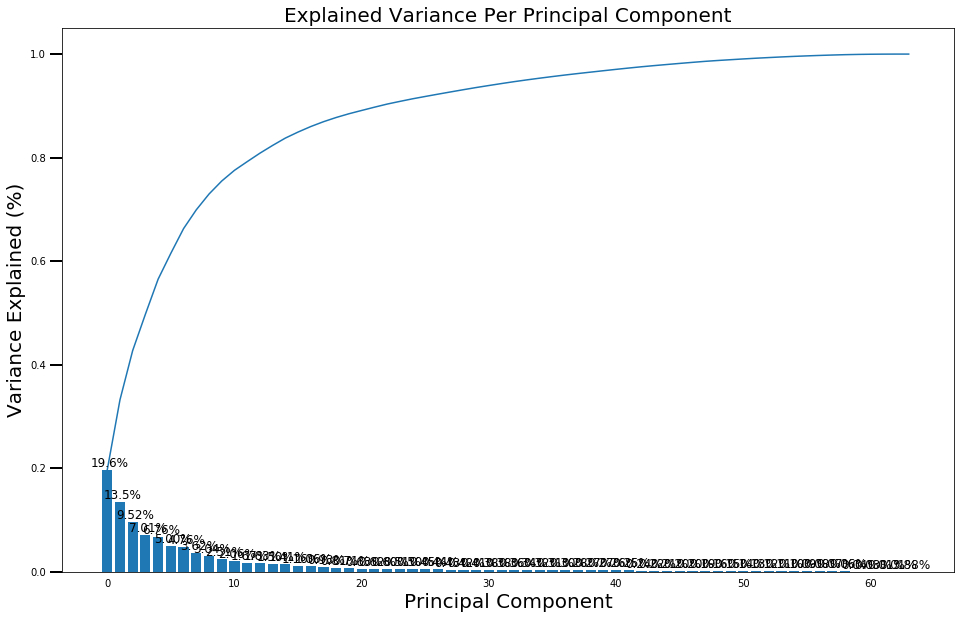

In [227]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [228]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=45)
azdias_pca = pca.fit_transform(azdias)

###  Perform Dimensionality Reduction


The above plot shows the variance explained by each principal components. Look like approximately 98% of the variance is explained by 45 features, so 45 features are chosen to re-do the PCA. 


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list.
- Also, investigate and interpret feature associations from the first three principal components in this substep.

In [229]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that can be reused in the
# other cells.

def print_component(pca, comp):
    df = pd.DataFrame({ 'featurs': azdias.columns ,'weight component_ '+str(comp): pca.components_[comp]})
    df['abs_W'] = df['weight component_ '+str(comp)].abs()  
    df = df.sort_values(by=['abs_W'],  ascending=False)
    df = df[['featurs', 'weight component_ '+str(comp)]]
    
    return df


In [230]:
df_1 = print_component(pca, 0)
df_1

,featurs,weight component_ 0
35,MIN_GEBAEUDEJAHR,-0.597187
32,ANZ_HAUSHALTE_AKTIV,0.401853
53,PLZ8_ANTG3,0.224582
51,PLZ8_ANTG1,-0.215096
56,PLZ8_GBZ,-0.193819
54,PLZ8_ANTG4,0.161547
29,HH_EINKOMMEN_SCORE,0.159055
58,ORTSGR_KLS9,0.158380
52,PLZ8_ANTG2,0.145462
47,MOBI_REGIO,-0.139527


In [231]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
df_2 = print_component(pca, 1)
df_2

,featurs,weight component_ 1
35,MIN_GEBAEUDEJAHR,0.767759
32,ANZ_HAUSHALTE_AKTIV,0.299822
31,WOHNDAUER_2008,-0.255222
51,PLZ8_ANTG1,-0.160765
47,MOBI_REGIO,-0.160641
56,PLZ8_GBZ,-0.151458
53,PLZ8_ANTG3,0.138429
54,PLZ8_ANTG4,0.111880
41,KBA05_GBZ,-0.103198
57,ARBEIT,0.097590


In [232]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
df_3 = print_component(pca, 2)
df_3

,featurs,weight component_ 2
31,WOHNDAUER_2008,0.735301
32,ANZ_HAUSHALTE_AKTIV,0.272013
13,SEMIO_REL,-0.247183
35,MIN_GEBAEUDEJAHR,0.177134
19,SEMIO_RAT,-0.168921
23,SEMIO_PFLICHT,-0.153947
24,SEMIO_TRADV,-0.141079
0,ALTERSKATEGORIE_GROB,0.140004
17,SEMIO_ERL,0.129627
3,FINANZ_SPARER,-0.127314


### Interpret Principal Components


The first principal component is strongly correlated with two original variables i.e. "MIN_GEBAEUDEJAHR" (negative), and "ANZ_HAUSHALTE_AKTIV" (positive). The negative correlation value indicates that the first principal component increases with decreasing the "MIN_GEBAEUDEJAHR" which explains the first year a building was mentioned in the database. Another variable "ANZ_HAUSHALTE_AKTIV" shows strong positive correlation which indicates the first principal component increases with increasing of the number of households in the building.


The second principal component is correlated with 'MIN_GEBAEUDEJAHR' (positive) variable. It increases with increase in the first year a building was mentioned in the database. This component can be viewed as a measure of the age of a building in the database.

The third principal component is strongly correlated with 'WOHNDAUER_2008' (positive) variable. It increases with increase in the length of residence. So It can be viewed as a measure of the length of residence.


## Clustering

### Apply Clustering to General Population

Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.


In [233]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
    
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to the data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    
    score = np.abs(model.score(data))
    
    return score
    

In [234]:
scores = []

centers = np.arange(15, 30, 1)

for center in centers: 
    print(center)
    scores.append(get_kmeans_score(azdias_pca, center))

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


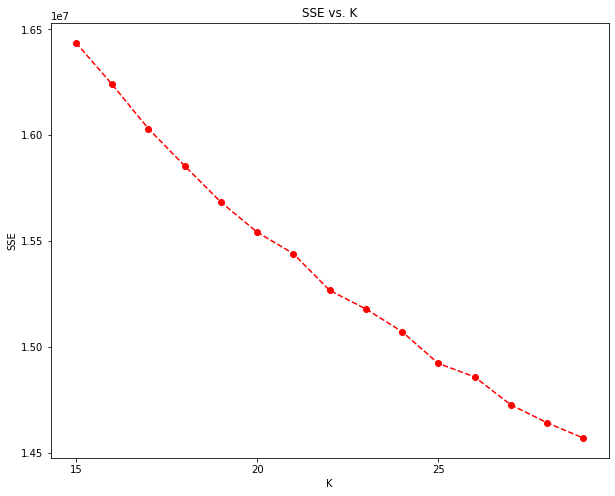

In [235]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10, 8)) 
plt.plot(centers, scores, linestyle='--', marker='o', color='r')
matplotlib.rc('xtick', labelsize=30)  
matplotlib.rc('ytick', labelsize=30)
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.show()

In [236]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=25)
labels_azdias = kmeans.fit_predict(azdias_pca)

In [237]:
cls_azdias = pd.DataFrame( { 'cluster':pd.Series(labels_azdias).value_counts().index , \
                    '% of data': 100*pd.Series(labels_azdias).value_counts().values/len(labels_azdias)})
cls_azdias['data'] = 'general population'

In [238]:
cls_azdias.head()

,cluster,% of data,data
0,8,6.497509,general population
1,3,5.563006,general population
2,19,5.369781,general population
3,23,5.339448,general population
4,16,5.260712,general population


### Apply Clustering to General Population

The above plot ("SSE vs K") shows that the score decreases with K value but there is no obvious elbow is noticed. So, 25 cluster are chosen in order to have a significant number of clusters.  


### Apply All Steps to the Customer Data

Now, it's time to see how the customer data maps on to those clusters. T In the last step of the project, I will interpret how the general population fits apply to the customer data.

In [242]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [243]:
customers = clean_data(customers)

In [244]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136159 entries, 0 to 191651
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB              135947 non-null float64
ANREDE_KZ                         136159 non-null float64
FINANZ_MINIMALIST                 136159 non-null float64
FINANZ_SPARER                     136159 non-null float64
FINANZ_VORSORGER                  136159 non-null float64
FINANZ_ANLEGER                    136159 non-null float64
FINANZ_UNAUFFAELLIGER             136159 non-null float64
FINANZ_HAUSBAUER                  136159 non-null float64
GREEN_AVANTGARDE                  136159 non-null int64
HEALTH_TYP                        134133 non-null float64
RETOURTYP_BK_S                    136159 non-null float64
SEMIO_SOZ                         136159 non-null float64
SEMIO_FAM                         136159 non-null float64
SEMIO_REL                         136159 non-null float64
SEMIO_MAT                         136159 non-null float64
SEMIO_VERT           

In [245]:
customers = pd.DataFrame( Imp.transform(customers.values), columns=customers.columns)

In [246]:
customers = pd.DataFrame(scaler.transform(customers.values), columns=customers.columns)

In [247]:
customers.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
count,136159.000000,136159.000000,136159.000000,136159.000000,136159.000000,136159.000000,136159.000000,136159.000000,136159.000000,136159.000000,...,136159.000000,136159.000000,136159.000000,136159.000000,136159.000000,136159.000000,136159.000000,136159.000000,136159.000000,136159.000000
mean,0.246690,-0.670356,0.635221,-0.526213,0.190750,-0.467975,-0.051856,-0.129488,0.501311,-0.018853,...,-0.464435,0.630601,0.619526,-0.172783,0.037008,-0.051770,-0.701197,0.501311,-0.467108,0.122722
std,0.361698,0.470086,0.507687,0.274506,0.279060,0.332464,0.321216,0.657081,0.500000,0.776830,...,0.636070,0.932036,1.005692,1.009208,0.717944,0.708871,0.454256,0.500000,0.469194,0.446950
min,-1.000000,-1.000000,-1.000000,-0.666667,-1.000000,-0.666667,-0.333333,-1.000000,0.000000,-1.000000,...,-1.000000,-2.000000,-2.000000,-2.000000,-1.333333,-1.000000,-1.333333,0.000000,-1.000000,-0.666667
25%,0.000000,-1.000000,0.500000,-0.666667,0.000000,-0.666667,-0.333333,-0.500000,0.000000,-1.000000,...,-1.000000,0.000000,0.000000,-1.000000,-0.333333,-0.500000,-1.000000,0.000000,-1.000000,-0.333333
50%,0.500000,-1.000000,1.000000,-0.666667,0.333333,-0.666667,0.000000,-0.500000,1.000000,0.000000,...,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.666667,1.000000,-0.666667,0.333333
75%,0.500000,0.000000,1.000000,-0.333333,0.333333,-0.333333,0.000000,0.500000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.666667,0.500000,-0.333333,1.000000,0.000000,0.333333
max,0.500000,0.000000,1.000000,0.666667,0.333333,0.666667,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.000000,2.000000,2.000000,1.333333,1.000000,0.333333,1.000000,0.333333,0.666667


In [248]:
customers_pca = pca.transform(customers)

In [249]:
labels_customers = kmeans.predict(customers_pca)

In [250]:

cls_customers = pd.DataFrame( { 'cluster':pd.Series(labels_customers).value_counts().index , \
        '% of data': 100*pd.Series(labels_customers).value_counts().values/len(labels_customers)})
cls_customers['data'] = 'customer'

In [251]:
cls_customers.head()

,cluster,% of data,data
0,0,18.255863,customer
1,7,10.820438,customer
2,24,10.338648,customer
3,8,8.369627,customer
4,23,8.222005,customer


### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.


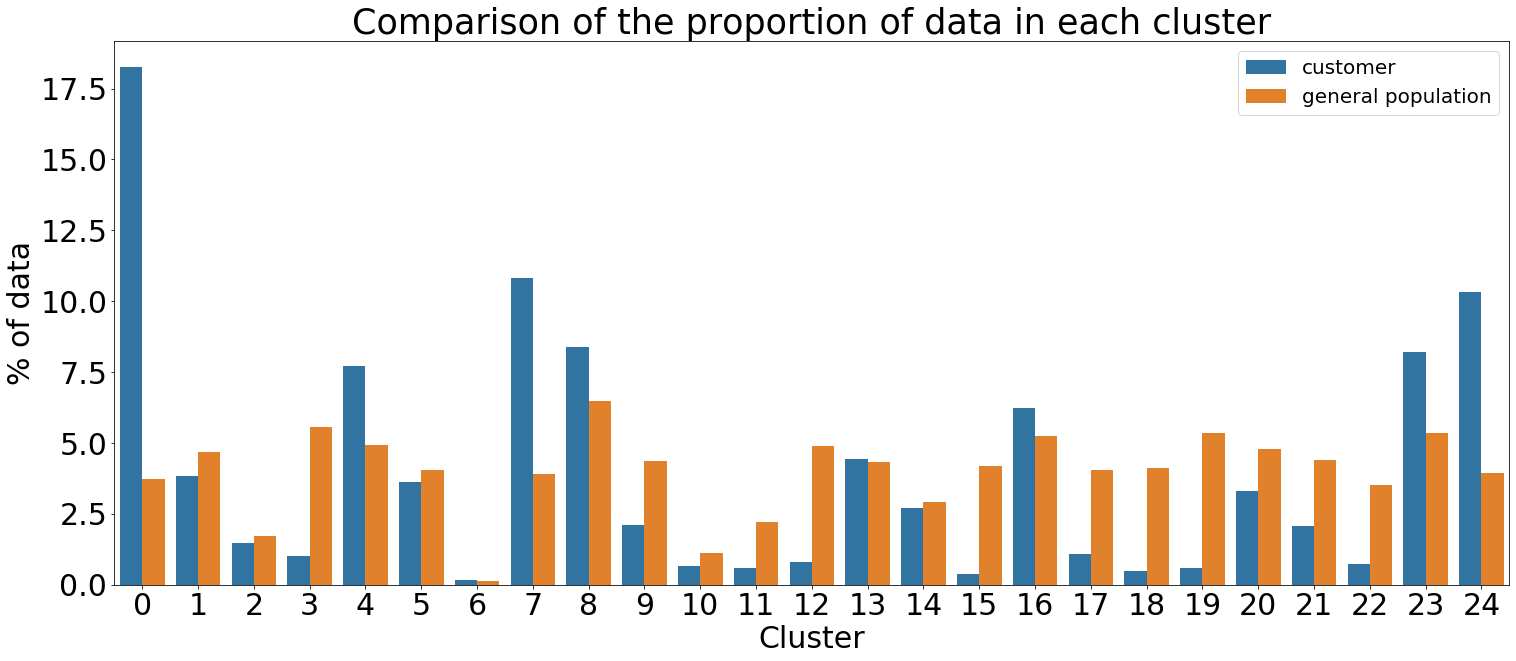

In [264]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

plt.figure(figsize=(25, 10))
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([cls_customers, cls_azdias]))
plt.xlabel("Cluster",fontsize=30)
plt.ylabel("% of data",fontsize=30)
plt.title("Comparison of the proportion of data in each cluster", fontsize=35)
plt.legend(fontsize=20)
plt.show()

In [265]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
data_cus_1 = scaler.inverse_transform(pca.inverse_transform(customers_pca[\
                                        np.where(labels_customers == 20)])).round()
df_1 = pd.DataFrame(data=data_cus_1, index=np.array(range(0, data_cus_1.shape[0])),
                    columns=customers.columns)
df_1.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
0,4.0,2.0,3.0,1.0,6.0,1.0,1.0,5.0,0.0,2.0,...,1.0,5.0,3.0,3.0,8.0,5.0,53.0,0.0,5.0,1.0
1,4.0,2.0,3.0,1.0,6.0,1.0,1.0,5.0,0.0,2.0,...,2.0,5.0,3.0,3.0,7.0,5.0,51.0,0.0,4.0,4.0
2,3.0,2.0,3.0,1.0,5.0,1.0,1.0,5.0,0.0,3.0,...,2.0,3.0,2.0,3.0,8.0,5.0,58.0,0.0,5.0,1.0
3,4.0,2.0,3.0,1.0,6.0,1.0,1.0,5.0,0.0,2.0,...,2.0,5.0,3.0,3.0,7.0,5.0,53.0,0.0,3.0,5.0
4,3.0,2.0,2.0,1.0,5.0,2.0,1.0,5.0,0.0,3.0,...,1.0,3.0,3.0,4.0,8.0,5.0,57.0,0.0,5.0,2.0


In [ ]:
data_cus_2 = scaler.inverse_transform(pca.inverse_transform(customers_pca[\
                                        np.where(labels_customers == 2)])).round()
df_2 = pd.DataFrame(data=data_cus_2, index=np.array(range(0, data_cus_2.shape[0])),
                    columns=customers.columns)
df_2.head()

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
data_az_1 = scaler.inverse_transform(pca.inverse_transform(azdias_pca[\
                                        np.where(labels_azdias == 9)])).round()
df_az_1 = pd.DataFrame(data=data_az_1, index=np.array(range(0, data_az_1.shape[0])),
                       columns=azdias.columns)
df_az_1.head()


In [ ]:
data_az_2 = scaler.inverse_transform(pca.inverse_transform(azdias_pca[\
                                        np.where(labels_azdias == 12)])).round()
df_az_2 = pd.DataFrame(data=data_az_2, index=np.array(range(0, data_az_2.shape[0])),
                       columns=azdias.columns)
df_az_2.head()

###  Compare Customer Data to Demographics Data

Looking at the bar plot above, we can clearly see that there is a good match between the clusters 3, 7, 11, 13 and 15. The ratio of these cluster are significantly higher in the customer data relative to the population data. These clusters have 46+ years of age, are male and have a high level of net income, likely to own a house and are from West Germany. 

The another clusters 0, 1, 6, 14, 17 and 22 are slightly different and there is a big difference between the clusters 2, 4, 8, 9, 10, 12, 19, 20, 21 and 24 in both the general population and the customers population datasets.

So, the company can use this info to select a part of the general population for their business. for example the mail-order company is popular with those who have high individualistic-accepting risks, higher Number of households in the building, may have small home office and are young, whereas the mail-order company is less popular with those who have high Number of professional academic title, are single low-income and average earners of younger age,are member of green avantgarde and are social-safety driven
